In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "mlr_hier_cov"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [4]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symm=True, perm=True)
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=2, mean_size=2500.0
level=2, num_groups=4, mean_size=1250.0
level=3, num_groups=8, mean_size=625.0
level=4, num_groups=16, mean_size=312.5
level=5, num_groups=5000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.95142542915701, noise_var=7.150831628949085
SNR=4.048679500710301, signal_to_noise=4


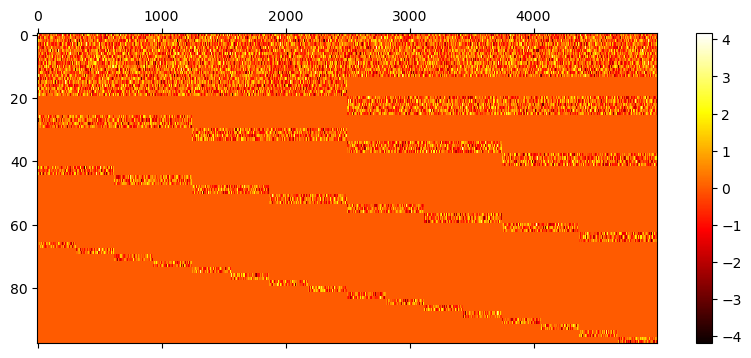

(5000, 98)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
C = hf.generate_data(true_sparse_F, true_D_noise, nsamples)

Z = C - C.mean(axis=1, keepdims=True)
A = Z @ Z.T / (Z.shape[1]-1)

# permute to put clusters on diagonal
Y = Z[hpart["rows"]["pi"], :].T
N = Y.shape[0]

In [8]:
ntest = 10**3
C_test = hf.generate_data(true_sparse_F, true_D_noise, ntest)

Z_test = C_test - C_test.mean(axis=1, keepdims=True)
# A_test = Z_test @ Z_test.T / (Z_test.shape[1]-1)

# permute to put clusters on diagonal
Y_test = Z_test[hpart["rows"]["pi"], :].T

In [9]:
type(true_sparse_F)

numpy.ndarray

In [10]:
perm_true_covariance = true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)
np.linalg.norm(A - perm_true_covariance, 'fro') / np.linalg.norm(perm_true_covariance, 'fro') 

0.4846808808376562

In [11]:
C.shape, Z.shape, A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [12]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(n)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

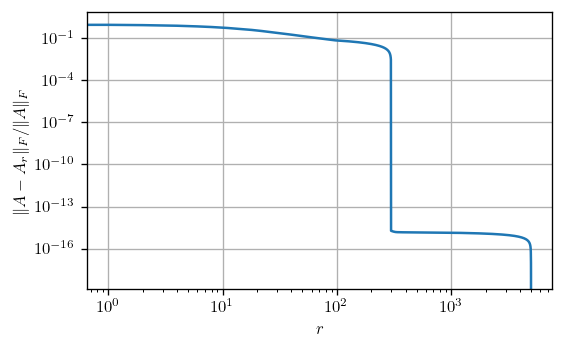

In [13]:
mf.plot_frob_error_rank(frob_losses)

In [14]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [15]:
row_selectors, si_groups, F_hpart = hf.row_col_selections(hpart)

num_levels=6, num_sparsities=16
(16, 5) [ 0  1  3  7 15]


# MLR Frobenius fit

In [16]:
obj_frobs = {}

print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = hpart
losses = hat_A.factor_fit(A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
lu, piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = hf.loglikelihood_value(Sigma_frob, lu, piv, Y)

obj_frob_test = hf.loglikelihood_value(Sigma_frob, lu, piv, Y_test)
print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")
obj_frobs[str(ranks)] = {"train":obj_frob, "test":obj_frob_test}

30


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.41345697049428526, [14  6  4  3  2  1]
itr=1, 0.41345697049428526, [14  6  4  3  2  1]
itr=1, 0.4130403753053981, [14  6  4  3  2  1], time_v_epoch=18.164539098739624, time_loss=0.8063747882843018
itr=2, 0.4130165226022896, [14  6  4  3  2  1], time_v_epoch=17.918226957321167, time_loss=0.8105580806732178
obj_frob = -13503.671974989844, obj_frob_test = -14226.006265976594


In [27]:
print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")

FR: train ll=-13503.671974989844, test ll=-14226.006265976594, losses[-1]=0.413011658725631


In [17]:
mf.rel_diff(hat_A.matrix(), den=A)

0.4130116587256327

# EM algorithm

### Random initialization

In [18]:
loglikelihoods = [-np.inf]
F0, D0 = np.random.randn(n, rank-1), np.square(np.random.rand(n)) + 1e-3

In [19]:
for t in range(350):
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj = hf.loglikelihood_value(Sigma0, lu, piv, Y)
    loglikelihoods += [obj]
    if t % 50 == 0:
        test_lu, test_piv = scipy.linalg.lu_factor(Sigma0)
        obj_test = hf.loglikelihood_value(Sigma0, test_lu, test_piv, Y_test)
        print(f"{t=}, {obj=}, {obj_test=}")
    F1 = hf.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
    D1 = hf.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

t=0, obj=-3799601.5756364586, obj_test=-3804676.267881869
t=50, obj=-13522.23064267305, obj_test=-14228.241269690912
t=100, obj=-13508.348688905844, obj_test=-14215.654807969135
t=150, obj=-13502.188180283521, obj_test=-14210.589523114466
t=200, obj=-13498.534129306066, obj_test=-14207.748696814979
t=250, obj=-13495.868565339855, obj_test=-14205.797341156984
t=300, obj=-13493.71143514083, obj_test=-14204.292758319685


In [20]:
ll_hier = np.copy(np.array(loglikelihoods))

In [21]:
Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=A[hat_A.pi_rows, :][:, hat_A.pi_cols]) #mf.rel_diff(Sigma0[hat_A.pi_inv_rows, :][:, hat_A.pi_inv_cols], den=A)

2.5116074838917792

In [22]:
test_lu, test_piv = scipy.linalg.lu_factor(Sigma0)
obj_test = hf.loglikelihood_value(Sigma0, test_lu, test_piv, Y_test)

print(f"ML: train ll={loglikelihoods[-1]}, test ll={obj_test}")
ll_hier = {"train":ll_hier, "test":obj_test}

ML: train ll=-13491.999016815547, test ll=-14203.048167867253


In [23]:
obj_frobs

{'[14  6  4  3  2  1]': {'train': -13503.671974989844,
  'test': -14226.006265976594}}

In [24]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

# True loglikelihoods

In [28]:
true_Sigma = hf.perm_hat_Sigma_sp(true_sparse_F, true_D_noise, F_hpart, ranks)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_test_obj = hf.loglikelihood_value(true_Sigma, lu, piv, Y_test)
true_train_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
print(f"TR: train ll={true_train_obj}, test ll={true_test_obj}")

TR: train ll=-48207.769282273846, test ll=-12100.551297274433


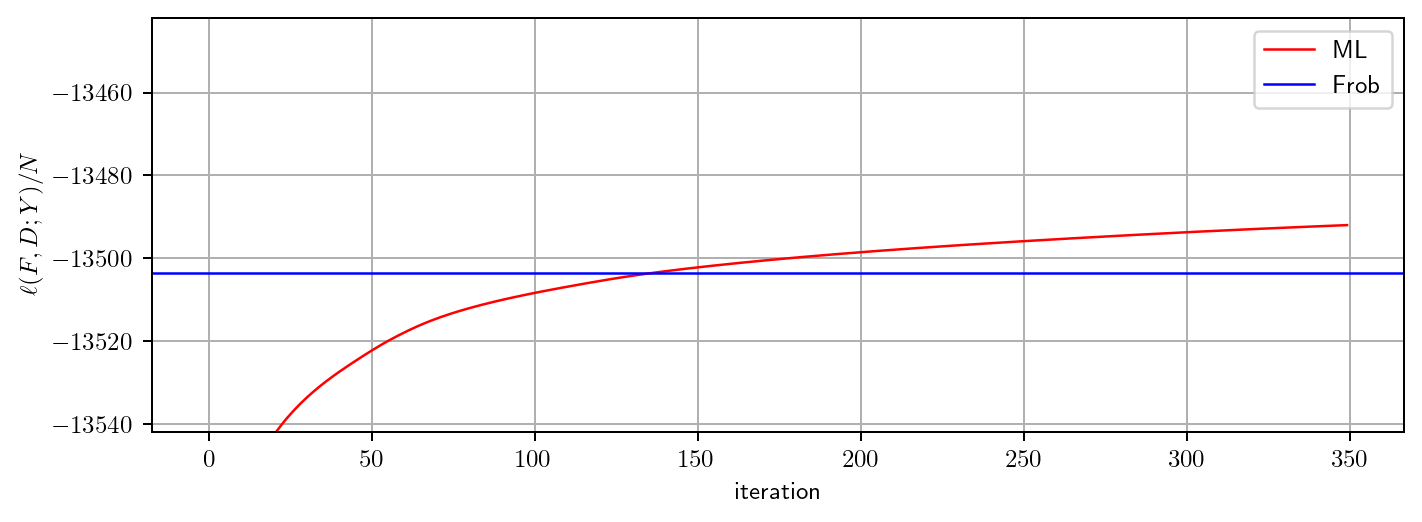

In [70]:
from matplotlib.ticker import SymmetricalLogLocator, ScalarFormatter

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(8, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{ML}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 50, ll.max() + 50])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
# yticks = [10**3*(ll.max()//1000) - 1000, 10**3*(ll.max()//1000) + 1000]
# axs.set_yticks(yticks)
# axs.set_yticklabels([str(ytick) for ytick in yticks])
# plt.gca().set_ylim(ll.max() - 100, ll.max() + 100)
# fig.suptitle("Observed data log-likelihood", fontsize=16, y=1.05)
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')